# Model-based attacks VS FGSM / iFGSM

## Preprocessing

In [1]:
%pip install tsai
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
SEED = 123
import random, os
import numpy as np
import torch

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tsai.models.all import ResCNN
import torch, torch.nn as nn, torch.nn.functional as F
from collections import defaultdict
import copy
import math
import optuna

from typing import Optional
import tsai.models.all as mdls
import random


In [3]:

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### EarlyStopping utility

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4, mode='min'):
        assert mode in ('min', 'max')
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best = None
        self.counter = 0
        self.should_stop = False

    def step(self, metric):
        if self.best is None:
            self.best = metric
            self.counter = 0
            return False
        improvement = (metric < self.best - self.min_delta) if self.mode == 'min' else (metric > self.best + self.min_delta)
        if improvement:
            self.best = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop


### Dataset preparation

In [6]:
TRAIN_PATH = Path('PowerCons_TRAIN.tsv')
TEST_PATH = Path('PowerCons_TEST.tsv')
BATCH_SIZE = 64
# EPOCHS = 50
# LR = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
def load_powercon(path: Path):
    df = pd.read_csv(path, sep='\t', header=None)
    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y).astype(np.int64)
    return X, y_encoded, le.classes_

In [8]:
X_train, y_train, classes_ = load_powercon(TRAIN_PATH)
X_test, y_test, _ = load_powercon(TEST_PATH)
n_classes = len(classes_)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape, 'n_classes:', n_classes)

Train shape: (180, 144, 1) Test shape: (180, 144, 1) n_classes: 2


In [9]:
class PowerConDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = PowerConDataset(X_train, y_train)
test_ds = PowerConDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [10]:
print(X_train.min(), X_train.max(), X_test.min(), X_test.max())

-1.6031435 6.4025993 -1.6804967 5.9844995


counts:
1    90
2    90
Name: 0, dtype: int64
shares:
1    0.5
2    0.5
Name: 0, dtype: float64


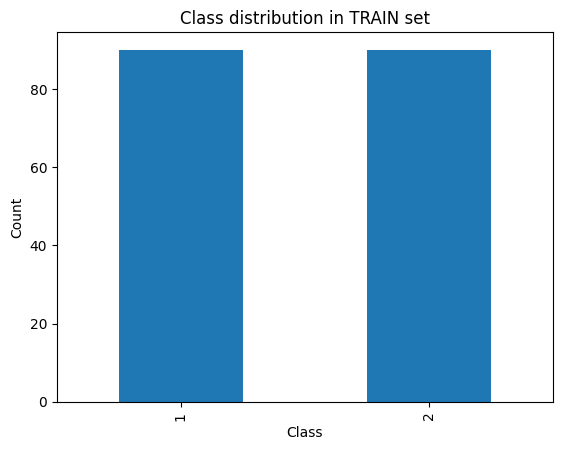

In [11]:
# check data-balance

df = pd.read_csv(TRAIN_PATH, sep='\t', header=None)

# 1. Считаем количество примеров каждого класса
label_counts = df.iloc[:, 0].value_counts().sort_index()
print(f'counts:\n{label_counts}')                # абсолютные значения
print(f'shares:\n{label_counts / len(df)}')      # доли

# 2. Быстрый бар-чарт
label_counts.plot.bar()
plt.title('Class distribution in TRAIN set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [12]:
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g)

## Classifiers

In [13]:
def accuracy(logits, target):
    return (logits.argmax(1) == target).float().mean().item()

In [14]:
class Activation(nn.Module):
    def __init__(self, kind='identity'):
        super().__init__()
        if kind == 'identity':
            self.act = nn.Identity()
        elif kind == 'relu':
            self.act = nn.ReLU()
        elif kind == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError(f'Unknown activation {kind}')
    def forward(self, x):
        return self.act(x)

### LSTM Classifier

In [15]:
class LSTMClassifier(nn.Module):
    def __init__(self, n_classes, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, n_classes)
    def forward(self, x):
        out, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])


### ResCNN Classifier

In [16]:
class ResCNNClassifier(nn.Module):
    def __init__(self, n_classes, x_dim=1, activation_type='identity', rescnn_kwargs=None):
        super().__init__()
        self.x_dim = x_dim
        rescnn_kwargs = rescnn_kwargs or {}

        # NN-backbone: tsai.models.ResCNN
        self.body = ResCNN(c_in=x_dim, c_out=n_classes, **rescnn_kwargs)
        self.fin = Activation(activation_type)

    def forward(self, x):
        # (B,L,C) or (B,C,L) —> (B,C,L)
        if x.ndim == 3 and x.shape[1] != self.x_dim:   # (B,L,C)
            x = x.transpose(1, 2)
        return self.fin(self.body(x))                  # logits

### Training classifiers

In [17]:
def train_classifier(model,
                     train_loader,
                     val_loader=None,
                     epochs=50,
                     lr=1e-3,
                     weight_decay=0.,
                     device="cpu",
                     patience=5,
                     verbose_every=3):
    """
    returns: dict(history), best_val_loss, best_state_dict
    """
    model.to(device)
    opt      = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    stopper  = EarlyStopping(patience=patience, mode="min") if val_loader else None
    history  = defaultdict(list)
    best_wts = model.state_dict()
    best_val = float("inf")

    for ep in range(1, epochs + 1):
        # ----- train -----
        model.train()
        loss_sum, acc_sum, n = 0., 0., 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss   = F.cross_entropy(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_sum += loss.item() * x.size(0)
            acc_sum  += (logits.argmax(1) == y).float().sum().item()
            n += x.size(0)

        train_loss = loss_sum / n
        train_acc  = acc_sum  / n
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # ----- validation -----
        if val_loader:
            model.eval()
            with torch.no_grad():
                loss_sum, acc_sum, n = 0., 0., 0
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    loss   = F.cross_entropy(logits, y)
                    loss_sum += loss.item() * x.size(0)
                    acc_sum  += (logits.argmax(1) == y).float().sum().item()
                    n += x.size(0)

            val_loss = loss_sum / n
            val_acc  = acc_sum  / n
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            if val_loss < best_val:
                best_val = val_loss
                best_wts = {k: v.cpu() for k, v in model.state_dict().items()}

            if stopper and stopper.step(val_loss):
                if verbose_every:
                    print(f"⏹ Early stopping on epoch {ep:02d}")
                break

        if verbose_every and ep % verbose_every == 0:
            msg = f"Epoch {ep:02d}: train_loss={train_loss:.4f} acc={train_acc:.4f}"
            if val_loader:
                msg += f" | val_loss={val_loss:.4f} acc={val_acc:.4f}"
            print(msg)

    model.load_state_dict(best_wts)
    return history, best_val, best_wts



#### train clf_LSTM

In [18]:
clf_LSTM = LSTMClassifier(n_classes, hidden_size=50, num_layers=1)

history, _, _=  train_classifier(
    clf_LSTM,
    train_dl,
    val_loader=test_dl,
    epochs=50,
    lr=1e-3,
    weight_decay=0.,
    device=device,
    patience=4,
    verbose_every=1
)

Epoch 01: train_loss=0.6898 acc=0.5000 | val_loss=0.6879 acc=0.5000
Epoch 02: train_loss=0.6860 acc=0.5000 | val_loss=0.6857 acc=0.5500
Epoch 03: train_loss=0.6827 acc=0.5778 | val_loss=0.6835 acc=0.6167
Epoch 04: train_loss=0.6805 acc=0.5778 | val_loss=0.6813 acc=0.5889
Epoch 05: train_loss=0.6777 acc=0.5611 | val_loss=0.6791 acc=0.5556
Epoch 06: train_loss=0.6743 acc=0.5833 | val_loss=0.6768 acc=0.5611
Epoch 07: train_loss=0.6708 acc=0.5722 | val_loss=0.6743 acc=0.5611
Epoch 08: train_loss=0.6660 acc=0.6056 | val_loss=0.6713 acc=0.5611
Epoch 09: train_loss=0.6606 acc=0.6056 | val_loss=0.6670 acc=0.5778
Epoch 10: train_loss=0.6513 acc=0.6278 | val_loss=0.6593 acc=0.5889
Epoch 11: train_loss=0.6329 acc=0.6556 | val_loss=0.6404 acc=0.6444
Epoch 12: train_loss=0.5962 acc=0.6889 | val_loss=0.5836 acc=0.6944
Epoch 13: train_loss=0.5140 acc=0.7722 | val_loss=0.4367 acc=0.8722
Epoch 14: train_loss=0.3818 acc=0.8500 | val_loss=0.3654 acc=0.8722
Epoch 15: train_loss=0.4509 acc=0.8167 | val_los

#### train clf_resCNN

In [19]:
clf_resCNN = ResCNNClassifier(n_classes=n_classes, x_dim=1).to(device)

history, best_val, best_state = train_classifier(
    clf_resCNN,
    train_loader=train_dl,
    val_loader=test_dl,
    epochs=4,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    patience=10,
    verbose_every=1
)

torch.save(best_state, "rescnn_classifier_best.pth")

Epoch 01: train_loss=0.4919 acc=0.6889 | val_loss=0.5004 acc=0.8444
Epoch 02: train_loss=0.3612 acc=0.8444 | val_loss=0.4718 acc=0.7833
Epoch 03: train_loss=0.3397 acc=0.8667 | val_loss=0.4015 acc=0.8444
Epoch 04: train_loss=0.3095 acc=0.8667 | val_loss=0.3365 acc=0.8722


#### optuna for LSTM clf

In [20]:
def objective(trial):
    # --- hyperparams ---
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    patience  = trial.suggest_int("patience", 3, 10)
    dropout    = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    clf_model = LSTMClassifier(n_classes,
                               hidden_size=hidden_dim,
                               dropout=dropout)

    history, _, _=  train_classifier(clf_model,
                     train_dl,
                     val_loader=test_dl,
                     epochs=50,
                     lr=lr,
                     weight_decay=0.,
                     device=device,
                     patience=patience,
                     verbose_every=1)


    return history['val_acc'][-1]


# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))

# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST_PARAMS:", study.best_params)


## Adversarial Attacks

In [21]:
class Attack:
    def __init__(self, eps: float, clamp=(-1, 1)):
        self.eps = eps
        self.clamp = clamp

# class ModelBasedAttack(Attack):
#     def __init__(self, surrogate, eps, clamp=(-1, 1)):
#         super().__init__(eps, clamp)
#         self.surr = surrogate.eval()

#     @torch.no_grad()
#     def __call__(self, model, x, y):
#         delta = self.eps * torch.tanh(self.surr(x))
#         return torch.clamp(x + delta, *self.clamp)

class ModelBasedAttack(Attack):
    def __init__(self, attacker, eps, clamp=None, is_iter=False):
        super().__init__(eps, clamp)
        self.attacker = attacker.eval()
        self.is_iter = is_iter

    @torch.no_grad()
    def __call__(self, model, x, y):
        if not self.is_iter:
            # delta = self.eps * self.attacker(x).sign()
            delta = self.eps * torch.tanh(self.attacker(x))
            # print(f"L2 norm = {torch.norm(delta, p=2)}, L_infty norm = {torch.norm(delta, p=float('inf'))}")
            x_adv = x + delta
            if not self.clamp is None:
                x_adv = torch.clamp(x_adv, *self.clamp)
            return x_adv
        else:
            return self.attacker(x)


### train_atk_model

In [22]:
def train_atk_model(atk_model,
                    victim,
                    loader,
                    eps=0.5,
                    epochs=50,
                    lr=1e-4,
                    alpha_l2=1e-3,
                    device='cpu',
                    patience=4,
                    is_clamped=False,
                    is_debugged=False
                    ):
    atk_model.to(device)
    # victim.to(device).eval()
    victim.to(device).train()
    for param in victim.parameters():
      param.requires_grad_(False)
    opt = torch.optim.Adam(atk_model.parameters(), lr)
    stopper = EarlyStopping(patience=patience, mode="max")
    for ep in range(1, epochs+1):
        atk_model.train()
        run_vloss, run_acc, n = 0., 0., 0


        for x, y in loader:
            x, y = x.to(device), y.to(device)

            # atk_model.eval()
            delta = eps * torch.tanh(atk_model(x))
            # atk_model.train()

            if is_clamped:
                delta = torch.clamp(delta, -1, 1)

            # x_adv = torch.clamp(x + delta, -1, 1)

            x_adv = x + delta
            logits = victim(x_adv)

            vloss = F.cross_entropy(logits, y)
            acc = (logits.argmax(1) == y).float().mean().item()
            reg = alpha_l2 * (delta**2).mean()
            loss = -(vloss - reg)
            if is_debugged:
                print(f'\nx={((x[0].detach().cpu()**2).mean())**0.5}')
                print(f'delta={((delta[0].detach().cpu()**2).mean())**0.5}')
                print(f'y={y.detach().cpu()[0]}|logits={logits.detach().cpu().argmax(1)[0]}')
                print(f'vloss = {vloss}| reg = {reg}')

                with torch.no_grad():
                    # ----- (2) % L2-нормы входа -----
                    # L2 посчитаем по каждому объекту, затем усредним
                    l2_delta = torch.norm(delta.view(delta.size(0), -1), p=2, dim=1)
                    l2_x_adv = torch.norm(x_adv.view(x_adv.size(0), -1), p=2, dim=1) + 1e-8
                    l2_x     = torch.norm(x.view(x.size(0), -1),     p=2, dim=1) + 1e-8
                    perc_l2_x_adv  = (l2_delta / l2_x_adv * 100).mean().item()
                    perc_l2_x  = (l2_x_adv / l2_x * 100).mean().item()

                print(f'\nL2:Δ/x_adv: {perc_l2_x_adv:6.2f}%   x_adv/x: {perc_l2_x:6.2f}%')


            opt.zero_grad()
            loss.backward()
            opt.step()
            run_vloss += vloss.item()*x.size(0)
            run_acc += acc * x.size(0)
            n += x.size(0)

        val_loss = run_vloss / n
        print(f'\nEpoch {ep:02d} | victim‑loss {val_loss:.4f} | acc {run_acc/n:.4f}')
        if stopper.step(val_loss):
            print(f'⏹ Early stopping at epoch {ep}')
            break
    torch.save(atk_model.state_dict(), 'surrogate_maxloss.pth')
    return val_loss, run_acc/n


### LSTM Attack

In [23]:


class attack_LSTM(nn.Module):
    def __init__(self, hidden_dim=64, x_dim=1, activation_type='identity', dropout=0.25):
        super().__init__()
        self.rnn_inp = nn.LSTM(x_dim, hidden_dim, num_layers=3, batch_first=True, dropout=dropout)
        self.act = Activation(activation_type)
        # ! delete fc
        self.rnn_out = nn.LSTM(hidden_dim, x_dim, num_layers=3, batch_first=True, dropout=dropout)
        # self.fc = nn.Linear(hidden_dim, x_dim)
    def forward(self, data):
        x, _ = self.rnn_inp(data)
        x = self.act(x)
        x, _ = self.rnn_out(x)
        return x


#### train

In [24]:

"""
best params:
{'eps': 1.371353432117841, 'lr': 0.001749500764834404,
'alpha_l2': 0.000686630895888702, 'patience': 9,
'hidden_dim': 128, 'dropout': 0.6}

"""
atk_LSTM = attack_LSTM(hidden_dim=128, dropout=0.6, x_dim=1, activation_type='tanh').to(device)
for p in clf_LSTM.parameters():
    p.requires_grad_(False)
# clf_LSTM.eval()

eps_LSTM = 1.371353
train_atk_model(atk_LSTM,
                clf_LSTM,
                train_dl,
                eps=eps_LSTM,
                epochs=20,
                lr=0.01749500,
                alpha_l2=0.00068663089588,
                device=device,
                patience=9
)


Epoch 01 | victim‑loss 0.4882 | acc 0.8056

Epoch 02 | victim‑loss 0.6758 | acc 0.7556

Epoch 03 | victim‑loss 0.9146 | acc 0.6944

Epoch 04 | victim‑loss 1.1237 | acc 0.6500

Epoch 05 | victim‑loss 1.3155 | acc 0.5944

Epoch 06 | victim‑loss 1.4963 | acc 0.5556

Epoch 07 | victim‑loss 1.6652 | acc 0.5278

Epoch 08 | victim‑loss 1.7865 | acc 0.5167

Epoch 09 | victim‑loss 1.9001 | acc 0.5000

Epoch 10 | victim‑loss 1.9644 | acc 0.5000

Epoch 11 | victim‑loss 1.9990 | acc 0.5000

Epoch 12 | victim‑loss 2.0213 | acc 0.5000

Epoch 13 | victim‑loss 2.0364 | acc 0.5000

Epoch 14 | victim‑loss 2.0492 | acc 0.5000

Epoch 15 | victim‑loss 2.0589 | acc 0.5000

Epoch 16 | victim‑loss 2.0673 | acc 0.5000

Epoch 17 | victim‑loss 2.0753 | acc 0.5000

Epoch 18 | victim‑loss 2.0821 | acc 0.5000

Epoch 19 | victim‑loss 2.0874 | acc 0.5000

Epoch 20 | victim‑loss 2.0927 | acc 0.5000


(2.0926746924718223, 0.5000000026490953)

#### optuna

In [25]:
def objective(trial):
    # --- гиперпараметры ---
    eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
    patience  = trial.suggest_int("patience", 3, 10)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)

    atk_model = attack_LSTM(
        hidden_dim=hidden_dim, x_dim=1,
        activation_type='tanh', dropout=dropout
    )

    val_loss, val_acc = train_atk_model(
        atk_model, clf_LSTM, train_dl,
        eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=device, patience=patience
    )

    return val_acc

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))

# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST PARAMS:", study.best_params)


### ResCNN Attack

In [26]:
class ResCNNModel(nn.Module):
    def __init__(self, x_dim=1, output_dim=n_classes,
                 activation_type='identity',
                 rescnn_kwargs=None):
        super().__init__()
        self.x_dim = x_dim
        rescnn_kwargs = rescnn_kwargs or {}
        self.body = ResCNN(c_in=x_dim, c_out=output_dim, **rescnn_kwargs)
        self.fin = Activation(activation_type)
    def forward(self, x):
        if x.ndim == 3 and x.shape[1] != self.x_dim:
            x = x.transpose(1, 2)
        return self.fin(self.body(x))

class AttackCNN(nn.Module):
    def __init__(self, hidden_dim=128, x_dim=1, activation_type='tanh'):
        super().__init__()
        self.step_cnn = ResCNNModel(x_dim=x_dim, output_dim=hidden_dim, activation_type='identity')
        self.fc = nn.Linear(hidden_dim, x_dim)
        self.act = Activation(activation_type)
    def forward(self, x):
        B, L, C = x.shape
        x_flat = x.contiguous().view(B * L, 1, C)
        h = self.step_cnn(x_flat)
        h = h.view(B, L, -1)
        return self.fc(self.act(h))
        # return self.act(h)


#### train

In [27]:
atk_resCNN = AttackCNN().to(device)
atk_resCNN = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh').to(device)

'''
#! training is very sensitive to random-seed
weights were obtained with the parameters:
{'eps': 1.9910549963365909, 'lr': 0.0021041627898080928,
'alpha_l2': 4.549583575912758e-05, 'patience': 6}
'''
weights_path = 'weights/surr_resCNNfc_CPU_0.28.pth'
# weights_path = 'weights/surrogate_resCNN_fc_0.3.pth'
# atk_resCNN.load_state_dict(torch.load(weights_path, map_location=device))

eps_resCNN = 1.9910549963365909
train_atk_model(atk_resCNN, clf_LSTM, train_dl,
                eps=eps_resCNN,
                epochs=50, lr=0.00021041627898080928, alpha_l2=4.549583575912758e-05,
                device=device, patience=10, is_debugged=False)


Epoch 01 | victim‑loss 0.4964 | acc 0.8222

Epoch 02 | victim‑loss 1.3770 | acc 0.6556

Epoch 03 | victim‑loss 1.9841 | acc 0.4722

Epoch 04 | victim‑loss 2.7166 | acc 0.2722

Epoch 05 | victim‑loss 2.9237 | acc 0.2056

Epoch 06 | victim‑loss 3.0171 | acc 0.1611

Epoch 07 | victim‑loss 3.0922 | acc 0.1222

Epoch 08 | victim‑loss 3.1475 | acc 0.1333

Epoch 09 | victim‑loss 3.1876 | acc 0.1222

Epoch 10 | victim‑loss 3.1442 | acc 0.1278

Epoch 11 | victim‑loss 3.1958 | acc 0.1278

Epoch 12 | victim‑loss 3.1186 | acc 0.1222

Epoch 13 | victim‑loss 3.2461 | acc 0.1167

Epoch 14 | victim‑loss 3.2324 | acc 0.1167

Epoch 15 | victim‑loss 3.1913 | acc 0.1056

Epoch 16 | victim‑loss 3.2408 | acc 0.1000

Epoch 17 | victim‑loss 3.2142 | acc 0.1000

Epoch 18 | victim‑loss 3.2366 | acc 0.1111

Epoch 19 | victim‑loss 3.2461 | acc 0.1167

Epoch 20 | victim‑loss 3.2417 | acc 0.1167

Epoch 21 | victim‑loss 3.2331 | acc 0.1222

Epoch 22 | victim‑loss 3.2656 | acc 0.1167

Epoch 23 | victim‑loss 3.2316 |

(3.1607863585154217, 0.11666666749450895)

#### optuna

In [28]:
def objective(trial):
    eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
    patience  = trial.suggest_int("patience", 3, 10)

    atk_model = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh')

    val_loss, val_acc = train_atk_model(
        atk_model, clf_LSTM, train_dl,
        eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=device, patience=patience
    )

    return val_acc

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))
# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST PARAMS:", study.best_params)


### PatchTST Attack

In [29]:
loader = train_dl
x, _ = next(iter(loader))
seq_len = x.size(1)           # длина последовательности
print("Sequence length =", seq_len)


Sequence length = 144


In [30]:
class BaseModel(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.self_supervised = False

class PatchTST(BaseModel):
    def __init__(self, activation_type: str = "sigmoid", **kwargs) -> None:
        super().__init__()
        self.model = mdls.PatchTST(**kwargs).float()
        self.final_activation = Activation(activation_type)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = X.transpose(1, 2)
        output = self.model(X)
        return self.final_activation(output).squeeze(-1)


class AttackPatchTST(nn.Module):
    def __init__(
        self,
        hidden_dim: int = 128,
        x_dim: int = 1,
        activation_type: str = "tanh",
        patch_kwargs: Optional[dict] = None,
    ):
        super().__init__()

        patch_kwargs = patch_kwargs or {}
        # гарантируем нужный выход PatchTST
        patch_kwargs.update(dict(c_in=x_dim,
                                 c_out=hidden_dim,
                                 pred_dim=hidden_dim))

        self.step_model = PatchTST(activation_type="identity", **patch_kwargs)
        self.fc        = nn.Linear(hidden_dim, x_dim)
        self.act       = Activation(activation_type)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.shape
        h = self.step_model(x)          # (B, 1, 1, hidden_dim)

        h = h.view(B, -1)
        # либо h = h.squeeze(1).squeeze(1)

        h = h.unsqueeze(1).expand(-1, L, -1)   # (B, L, hidden_dim)
        return self.fc(self.act(h))            # (B, L, C)


#### train

In [31]:
patch_params = dict(
    seq_len=144,
    n_layers=3,
    n_heads=8,
    d_model=512,
    d_ff=2048,
    dropout=0.4,
    attn_dropout=0.0,
    patch_len=28,
    stride=24,
    padding_patch=True,
    revin=True,
    affine=False,
    individual=False,
    subtract_last=False,
    decomposition=False,
    kernel_size=25,
    activation="gelu",
    norm="BatchNorm",
    pre_norm=False,
    res_attention=True,
    store_attn=False,
)

atk_PatchTST = AttackPatchTST(
    hidden_dim=256,
    x_dim=1,
    activation_type="tanh",
    patch_kwargs=patch_params,
)

eps_PatchTST = 1.52738926
train_atk_model(atk_PatchTST, clf_resCNN, train_dl,
                eps=eps_PatchTST,
                epochs=50, lr=0.000202314, alpha_l2=0.000114732,
                device=device, patience=8, is_debugged=False)


Epoch 01 | victim‑loss 1.4696 | acc 0.5111

Epoch 02 | victim‑loss 2.5844 | acc 0.2611

Epoch 03 | victim‑loss 2.9000 | acc 0.1722

Epoch 04 | victim‑loss 3.1129 | acc 0.0944

Epoch 05 | victim‑loss 3.1189 | acc 0.1167

Epoch 06 | victim‑loss 3.1631 | acc 0.1000



Epoch 07 | victim‑loss 3.2354 | acc 0.0833

Epoch 08 | victim‑loss 3.2592 | acc 0.0722

Epoch 09 | victim‑loss 3.2797 | acc 0.0778

Epoch 10 | victim‑loss 3.2918 | acc 0.0722

Epoch 11 | victim‑loss 3.3187 | acc 0.0722

Epoch 12 | victim‑loss 3.3152 | acc 0.0722

Epoch 13 | victim‑loss 3.3351 | acc 0.0722

Epoch 14 | victim‑loss 3.3455 | acc 0.0778

Epoch 15 | victim‑loss 3.3391 | acc 0.0667

Epoch 16 | victim‑loss 3.3176 | acc 0.0611

Epoch 17 | victim‑loss 3.3584 | acc 0.0556

Epoch 18 | victim‑loss 3.3464 | acc 0.0611

Epoch 19 | victim‑loss 3.3243 | acc 0.0500

Epoch 20 | victim‑loss 3.3557 | acc 0.0500

Epoch 21 | victim‑loss 3.3622 | acc 0.0500

Epoch 22 | victim‑loss 3.3627 | acc 0.0611

Epoch 23 | victim‑loss 3.3603 | acc 0.0611

Epoch 24 | victim‑loss 3.3219 | acc 0.0500

Epoch 25 | victim‑loss 3.3642 | acc 0.0556

Epoch 26 | victim‑loss 3.3642 | acc 0.0556

Epoch 27 | victim‑loss 3.3204 | acc 0.0556

Epoch 28 | victim‑loss 3.3700 | acc 0.0611

Epoch 29 | victim‑loss 3.3341 |

(3.364581478966607, 0.05000000020696057)

#### optuna

In [32]:
SEQ_LEN  = seq_len
X_DIM    = 1
DEVICE   = device
VICTIM   = clf_resCNN
TRAIN_DL = train_dl

def objective(trial: optuna.Trial):

    # atk params
    eps        = trial.suggest_float("eps",        0.1, 0.5,    log=True)
    lr         = trial.suggest_float("lr",         1e-4, 1e-2,  log=True)
    alpha_l2   = trial.suggest_float("alpha_l2",   1e-5, 1e-2,  log=True)
    patience   = trial.suggest_int  ("patience",   3, 10)

    # architecture
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    # main hyperparams
    patch_len  = trial.suggest_int("patch_len", 8, 32, step=4)
    stride_max = patch_len                      # stride не может превышать patch_len
    stride     = trial.suggest_int("stride",    4, stride_max, step=4)
    n_layers   = trial.suggest_int("n_layers",  1, 4)
    d_model    = trial.suggest_categorical("d_model", [256, 512, 768])
    dropout    = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)

    # подготовим patch-kwargs
    patch_kwargs = dict(
        seq_len       = SEQ_LEN,
        n_layers      = n_layers,
        n_heads       = 8,
        d_model       = d_model,
        d_ff          = 4 * d_model,
        dropout       = dropout,
        attn_dropout  = 0.0,
        patch_len     = patch_len,
        stride        = stride,
        padding_patch = True,
        revin         = True,
        affine        = False,
        individual    = False,
        subtract_last = False,
        decomposition = False,
        kernel_size   = 25,
        activation    = "gelu",
        norm          = "BatchNorm",
        pre_norm      = False,
        res_attention = True,
        store_attn    = False,
    )

    surrogate = AttackPatchTST(
        hidden_dim     = hidden_dim,
        x_dim          = X_DIM,
        activation_type= "tanh",
        patch_kwargs   = patch_kwargs
    )

    val_loss, val_acc = train_atk_model(
        surrogate, VICTIM, TRAIN_DL,
        eps=eps, epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=DEVICE, patience=patience
    )

    return val_acc


# sampler = optuna.samplers.TPESampler()
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=3)

# study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
# study.optimize(objective, n_trials=50, timeout=60*60)

# print("BEST PARAMS:", study.best_params)


### FGSM && iFGSM

In [33]:
class FGSMAttack(Attack):
    def __call__(self, model, x, y):
        x_req = x.clone().detach().requires_grad_(True)
        loss = F.cross_entropy(model(x_req), y)
        loss.backward()
        delta = self.eps * x_req.grad.sign()
        # print(f"FGSM L2 norm = {torch.norm(delta, p=2)}, L_infty norm = {torch.norm(delta, p=float('inf'))}")
        x_adv = x + delta
        if not self.clamp is None:
          x_adv = torch.clamp(x_adv, *self.clamp)
        return x_adv.detach()

class iFGSMAttack(Attack):
    def __init__(self, eps, n_iter=20, alpha=None, clamp=None,
                 rand_init=True, momentum=0.9):
        super().__init__(eps, clamp)
        self.n_iter, self.alpha = n_iter, alpha or 1.5*eps/n_iter
        self.rand_init, self.mu = rand_init, momentum

    def __call__(self, model, x, y):
        x_adv = x.detach()
        if self.rand_init:
            x_adv = x_adv + torch.empty_like(x).uniform_(-self.eps, self.eps)
            if not self.clamp is None:
              x_adv = torch.clamp(x_adv, *self.clamp)
        g = torch.zeros_like(x)
        for _ in range(self.n_iter):
            x_adv.requires_grad_(True)
            loss = F.cross_entropy(model(x_adv), y)
            model.zero_grad(); loss.backward()
            grad = x_adv.grad / x_adv.grad.abs().mean(dim=(1,2), keepdim=True)
            g = self.mu * g + grad
            x_adv = x_adv + self.alpha * g.sign()
            delta = torch.clamp(x_adv - x, min=-self.eps, max=self.eps)
            x_adv = x + delta
            if not self.clamp is None:
              x_adv = torch.clamp(x_adv, *self.clamp)
            x_adv = x_adv.detach()
        # print(f"iFGSM L2 norm = {torch.norm(x_adv - x, p=2)}, L_infty norm = {torch.norm(x_adv - x, p=float('inf'))}")
        return x_adv

### Iter model-based attack

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- straight-through clamp/projection (BPDA) ---
class _STClamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lo, hi):
        return x.clamp(lo, hi)
    @staticmethod
    def backward(ctx, g):
        return g, None, None

def st_clamp(x, lo, hi, use_st: bool):
    return _STClamp.apply(x, lo, hi) if use_st else x.clamp(lo, hi)

def _normalize_step(d, kind: str | None):
    if kind in (None, "none"):
        return d
    if kind == "meanabs":
        s = d.abs().mean(dim=tuple(range(1, d.dim())), keepdim=True) + 1e-12
        return d / s
    if kind == "l2":
        s = torch.norm(d.flatten(1), p=2, dim=1).view(-1, *[1]*(d.dim()-1)) + 1e-12
        return d / s
    if kind == "linf":
        s = d.abs().flatten(1).amax(dim=1).view(-1, *[1]*(d.dim()-1)) + 1e-12
        return d / s
    raise ValueError(f"Unknown normalize kind: {kind}")

class IterModelAttackk(nn.Module):
    """
    x_{t+1} = Proj( Clamp( x_t + alpha * dir(attacker(x_t), momentum) ) ).
    Флаги по умолчанию повторяют твоё текущее поведение: БЕЗ проекции/клампа/моментума.
    """
    def __init__(
        self,
        attacker: nn.Module,
        eps: float,
        n_iter: int = 10,
        alpha: float | None = None,
        # --- сохранённые аргументы для совместимости ---
        clamp: tuple | None = None,        # было data_clamp в train-функции
        rand_init: bool = True,
        use_sign: bool = False,
        equal_eps: bool = False,
        bpda: bool = True,
        # --- новые флаги (все выключены по умолчанию) ---
        proj: str = "none",                # "none" | "linf" | "l2"
        proj_equal_eps: bool = False,      # дотягивать до ||δ|| = eps
        data_clamp: tuple | None = None,   # (min, max) по данным; по умолчанию None
        momentum_mu: float = 0.0,          # 0.0 = без momentum (как у тебя)
        step_normalize: str | None = None, # "meanabs" | "l2" | "linf" | None
        step_noise_std: float = 0.0,       # гаусс. шум в шаге (для стабилизации)
    ):
        super().__init__()
        self.attacker = attacker
        self.eps = eps
        self.n_iter = n_iter
        self.alpha = alpha or (1.0 * eps / max(1, n_iter))
        # совместимость:
        self.rand_init = rand_init
        self.use_sign = use_sign
        self.equal_eps = equal_eps
        self.bpda = bpda
        # новые опции:
        self.proj = proj
        self.proj_equal_eps = proj_equal_eps
        self.data_clamp = data_clamp if clamp is None else clamp  # поддержка старого имени
        self.momentum_mu = momentum_mu
        self.step_normalize = step_normalize
        self.step_noise_std = step_noise_std

    @staticmethod
    def _project(delta, eps, mode: str, equal_eps: bool, bpda: bool):
        if mode == "none":
            return delta
        if mode == "linf":
            delta = st_clamp(delta, -eps, eps, use_st=bpda)
            if equal_eps:
                amax = delta.detach().abs().flatten(1).amax(dim=1)  # (B,)
                scale = (eps / (amax + 1e-12)).view(-1, *[1]*(delta.dim()-1))
                delta = delta * scale
                delta = st_clamp(delta, -eps, eps, use_st=bpda)
            return delta
        if mode == "l2":
            flat = delta.flatten(1)
            nrm = torch.norm(flat, p=2, dim=1).view(-1, *[1]*(delta.dim()-1)) + 1e-12
            # проекция в L2-шар
            delta = delta * torch.clamp(eps / nrm, max=1.0)
            if equal_eps:
                delta = delta * (eps / (nrm + 1e-12))
            return delta
        raise ValueError(f"Unknown projection mode: {mode}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x0 = x
        # random start
        if self.rand_init:
            if self.proj == "linf":
                delta0 = torch.empty_like(x0).uniform_(-self.eps, self.eps)
            elif self.proj == "l2":
                delta0 = torch.randn_like(x0)
                delta0 = self._project(delta0, self.eps, "l2", False, self.bpda)
            else:  # none
                delta0 = torch.empty_like(x0).uniform_(-self.eps, self.eps)
            x_adv = x0 + delta0
        else:
            x_adv = x0.clone()

        g = torch.zeros_like(x_adv)  # momentum buffer

        for _ in range(self.n_iter):
            step_dir = self.attacker(x_adv)
            step_dir = step_dir.sign() if self.use_sign else torch.tanh(step_dir)
            if self.step_normalize:
                step_dir = _normalize_step(step_dir, self.step_normalize)
            if self.step_noise_std > 0:
                step_dir = step_dir + self.step_noise_std * torch.randn_like(step_dir)

            # momentum (как в MI-FGSM: накопление направления)
            if self.momentum_mu > 0.0:
                g = self.momentum_mu * g + step_dir
                step_dir = g.sign() if self.use_sign else g

            x_adv = x_adv + self.alpha * step_dir

            # проекция в ε-шар (если включена)
            delta = x_adv - x0
            delta = self._project(delta, self.eps, self.proj, self.proj_equal_eps, self.bpda)
            x_adv = x0 + delta

            # clamp по данным (если указан)
            if self.data_clamp is not None:
                x_adv = st_clamp(x_adv, self.data_clamp[0], self.data_clamp[1], use_st=self.bpda)

        return x_adv


In [41]:


#* -------------------------------------------------
#* light version of ModelIterAttack
#* -------------------------------------------------
# import torch
# import torch.nn as nn

# class DifferentiableModelIterAttack(nn.Module):
#     """
#     Итеративная атака без каких-либо проекций и clamp:
#     x_{t+1} = x_t + alpha * dir(attacker(x_t)),
#     где dir = sign(.) или tanh(.).
#     Никаких ограничений на ||x_t - x0|| и диапазон значений нет.
#     """
#     def __init__(
#         self,
#         attacker: nn.Module,
#         eps: float,
#         n_iter: int = 10,
#         alpha: float = None,
#         rand_init: bool = True,
#         use_sign: bool = False,
#         equal_eps: bool = False,  # не используется, оставлен для совместимости интерфейса
#         **kwargs                 # чтобы молча принимать старые аргументы (clamp, bpda и т.п.)
#     ):
#         super().__init__()
#         self.attacker  = attacker
#         self.eps       = eps
#         self.n_iter    = n_iter
#         self.alpha     = alpha or (1 * eps / max(1, n_iter))
#         self.rand_init = rand_init
#         self.use_sign  = use_sign

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x0 = x
#         if self.rand_init:
#             # случайный старт внутри [-eps, +eps] БЕЗ какой-либо проекции/клиппинга
#             delta0 = torch.empty_like(x0).uniform_(-self.eps, self.eps)
#             x_adv = x0 + delta0
#         else:
#             x_adv = x0.clone()

#         for _ in range(self.n_iter):
#             # направление шага от атакера
#             step_dir = self.attacker(x_adv)
#             step_dir = step_dir.sign() if self.use_sign else torch.tanh(step_dir)
#             # шаг без проекций/клиппинга
#             x_adv = x_adv + self.alpha * step_dir

#         return x_adv


#### train function

In [50]:

@torch.no_grad()
def _freeze_(m: nn.Module):
    for p in m.parameters():
        p.requires_grad_(False)

def train_attack_iter(
    attacker: nn.Module,
    victim: nn.Module,
    loader,
    eps=0.5,
    steps=10,
    alpha=None,
    epochs=50,
    lr=1e-4,
    alpha_l2=1e-3,
    lambda_disc=0.0,
    disc: nn.Module | None = None,
    device="cpu",
    patience=4,
    data_clamp=None,          # как раньше
    rand_init=True,
    use_sign=False,
    equal_eps=False,
    bpda=True,
    verbose=True,
    # ---- новые флаги (все опциональны, дефолты сохраняют прежнее поведение) ----
    proj: str = "none",       # "none" | "linf" | "l2"
    proj_equal_eps: bool = False,
    momentum_mu: float = 0.0, # MI-FGSM
    step_normalize: str | None = None,  # "meanabs" | "l2" | "linf" | None
    step_noise_std: float = 0.0,
    victim_eval: bool = True,
    grad_clip: float | None = None,
):
    attacker.to(device).train()
    victim.to(device)
    if victim_eval:
        victim.eval()
    _freeze_(victim)
    if disc is not None:
        disc.to(device).eval()
        _freeze_(disc)

    iter_attack = IterModelAttackk(
        attacker=attacker, eps=eps, n_iter=steps, alpha=alpha,
        clamp=data_clamp, rand_init=rand_init, use_sign=use_sign,
        equal_eps=equal_eps, bpda=bpda,
        proj=proj, proj_equal_eps=proj_equal_eps,
        data_clamp=data_clamp,
        momentum_mu=momentum_mu, step_normalize=step_normalize,
        step_noise_std=step_noise_std,
    ).to(device)

    opt = torch.optim.Adam(attacker.parameters(), lr=lr)
    stopper = EarlyStopping(patience=patience, mode="max")  # максимизируем victim-loss

    best_val, best_acc = float("-inf"), 0.0
    for ep in range(1, epochs+1):
        attacker.train()
        run_vloss, run_acc, n = 0.0, 0.0, 0

        for x, y in loader:
            x, y = x.to(device), y.to(device)
            x_adv = iter_attack(x)

            # ---- средняя норма по батчу ----
            if verbose:
                with torch.no_grad():
                    delta = (x_adv - x).detach()
                    # L2 по объектам, затем среднее по батчу
                    l2_mean = delta.view(delta.size(0), -1).norm(p=2, dim=1).mean().item()
                    # L_inf по объектам, затем среднее по батчу
                    linf_mean = delta.view(delta.size(0), -1).abs().amax(dim=1).mean().item()
                    x_mean = x.view(x.size(0), -1).norm(p=2, dim=1).mean().item()
                    x_adv_mean = x_adv.view(x_adv.size(0), -1).norm(p=2, dim=1).mean().item()
                print(f"[Δ] mean ||δ||_2 = {l2_mean:.3f} | mean ||δ||_∞ = {linf_mean:.3f}")
                print(f"[Δ] mean ||x||_2 = {x_mean:.3f} | mean ||x_adv||_2 = {x_adv_mean:.3f}")


            logits = victim(x_adv)
            vloss  = F.cross_entropy(logits, y)
            acc    = (logits.argmax(1) == y).float().mean().item()

            loss_disc = torch.tensor(0.0, device=device)
            if disc is not None:
                d_out = disc(x_adv)
                if d_out.dim() == 1 or d_out.size(-1) == 1:
                    target = torch.zeros_like(d_out)
                    loss_disc = nn.BCEWithLogitsLoss()(d_out, target)
                else:
                    target = torch.zeros(d_out.size(0), dtype=torch.long, device=device)
                    loss_disc = nn.CrossEntropyLoss()(d_out, target)

            delta = (x_adv - x)
            reg = alpha_l2 * (delta**2).mean()

            loss = -(vloss) + lambda_disc * loss_disc + reg

            opt.zero_grad()
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_norm_(attacker.parameters(), grad_clip)
            opt.step()

            run_vloss += vloss.item() * x.size(0)
            run_acc   += acc * x.size(0)
            n += x.size(0)

        val_loss = run_vloss / n
        val_acc  = run_acc / n
        if verbose:
            print(f"Epoch {ep:02d} | victim-loss {val_loss:.4f} | acc {val_acc:.4f}")

        
        if stopper.step(val_loss):
            if verbose: print(f"⏹ Early stopping at epoch {ep}")
            break

    torch.save(attacker.state_dict(), 'attacker_iter_unrolled.pth')
    return val_loss, val_acc


In [43]:

# * -------------------------------------------------
# * light version of ModelIterAttack
# * -------------------------------------------------

# @torch.no_grad()
# def _freeze_(m: nn.Module):
#     # m.eval()
#     for p in m.parameters():
#         p.requires_grad_(False)

# def train_attack_iter(
#     attacker: nn.Module,
#     victim: nn.Module,
#     loader,
#     eps=0.5,
#     steps=10,
#     alpha=None,
#     epochs=50,
#     lr=1e-4,
#     alpha_l2=1e-3,
#     lambda_disc=0.0,
#     disc: nn.Module | None = None,    # обученный дискриминатор D (опционально)
#     device=device,
#     patience=4,
#     data_clamp=(-1, 1),
#     rand_init=True,
#     use_sign=False,
#     equal_eps=False,
#     bpda=True,
#     verbose=True,
# ):
#     attacker.to(device).train()
#     victim.to(device)
#     _freeze_(victim)
#     if disc is not None:
#         disc.to(device)
#         _freeze_(disc)

#     # K-шаговый
#     iter_attack = IterModelAttack(
#         attacker=attacker, eps=eps, n_iter=steps, alpha=alpha,
#         clamp=data_clamp, rand_init=rand_init,
#         use_sign=use_sign, equal_eps=equal_eps, bpda=bpda
#     ).to(device)

#     opt = torch.optim.Adam(attacker.parameters(), lr=lr)
#     scheduler = None
#     stopper = EarlyStopping(patience=patience, mode="max")

#     best_val, best_acc = float('inf'), 0.0
#     for ep in range(1, epochs+1):
#         attacker.train()
#         run_vloss, run_acc, n = 0., 0., 0

#         for x, y in loader:
#             x, y = x.to(device), y.to(device)

#             # K-шаговый x_adv = Attack(x)
#             x_adv = iter_attack(x)
#             # Вычисление средней по бачу L2 нормы x_adv и x
#             l2_norm_x_adv_rms = torch.norm(x_adv, p=2, dim=1) / math.sqrt(x_adv.size(1))
#             l2_norm_x_rms = torch.norm(x, p=2, dim=1) / math.sqrt(x.size(1))
#             print(f"RMS норма x_adv: {l2_norm_x_adv_rms.mean().item():.3f}")
#             print(f"RMS норма x: {l2_norm_x_rms.mean().item():.3f}")

#             # потери
#             logits = victim(x_adv)

#             vloss = F.cross_entropy(logits, y)
#             acc   = (logits.argmax(1) == y).float().mean().item()

#             # скрытность (опционально): хотим, чтобы D(x_adv) -> "чисто" (0)
#             loss_disc = torch.tensor(0., device=device)
#             # if disc is not None:
#             #     d_out = disc(x_adv)
#             #     # если D обучен BCELoss(logit, y∈{0,1}), берём нули как цель «чисто»
#             #     # если мульткласс — подправь под свою реализацию
#             #     if d_out.dim() == 1 or d_out.size(-1) == 1:
#             #         target = torch.zeros_like(d_out)
#             #         bce = nn.BCEWithLogitsLoss()
#             #         loss_disc = bce(d_out, target)
#             #     else:
#             #         target = torch.zeros(d_out.size(0), dtype=torch.long, device=device)
#             #         ce = nn.CrossEntropyLoss()
#             #         loss_disc = ce(d_out, target)

#             # регуляризация по норме возмущения
#             delta = (x_adv - x)
#             reg = alpha_l2 * (delta**2).mean()

#             loss = -(vloss) + lambda_disc * loss_disc + reg

#             opt.zero_grad()
#             loss.backward()
#             opt.step()

#             run_vloss += vloss.item() * x.size(0)
#             run_acc   += acc * x.size(0)
#             n += x.size(0)

#         val_loss = run_vloss / n
#         val_acc  = run_acc / n
#         if verbose:
#             print(f"Epoch {ep:02d} | victim-loss {val_loss:.4f} | acc {val_acc:.4f}")

#         if scheduler:
#             scheduler.step()

#         if stopper.step(val_loss):
#             if verbose: print(f"⏹ Early stopping at epoch {ep}")
#             break

#     torch.save(attacker.state_dict(), 'attacker_iter_unrolled.pth')
#     return val_loss, val_acc


#### train

In [51]:

def prepare_victim_for_input_grad(victim: nn.Module):
    # 1) общий eval + заморозка весов
    victim.eval()
    for p in victim.parameters():
        p.requires_grad_(False)

    # 2) RNN в train(True), без dropout
    for m in victim.modules():
        if isinstance(m, (nn.LSTM, nn.GRU, nn.RNN)):
            m.train(True)
            if hasattr(m, 'dropout'):
                m.dropout = 0.0
            # иногда полезно обновить внутренние буферы для cuDNN
            try:
                m.flatten_parameters()
            except Exception:
                pass

    # 3) отключаем стохастику в явных Dropout, BN оставляем в eval
    for m in victim.modules():
        if isinstance(m, nn.Dropout):
            m.p = 0.0
            m.eval()
        elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
            m.eval()


In [52]:

# attacker = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh').to(device)
# try:
#     attacker.load_state_dict(atk_resCNN.state_dict())
#     print("[info] AttackCNN weights loaded from atk_resCNN.")
# except Exception as e:
#     print("[warn] Could not load atk_resCNN state_dict:", e)


attacker = AttackPatchTST(hidden_dim=256, x_dim=1, activation_type='tanh',
                          patch_kwargs=patch_params).to(device)
# attacker.load_state_dict(atk_PatchTST.state_dict())


target = clf_resCNN
prepare_victim_for_input_grad(target)

disc = None

# ====== Параметры из лучшего trial ======
# best = {
#     "eps": 0.30533993963027156,
#     "lr": 0.000013676824461798193,
#     "alpha_l2": 0.00033893444673716635,
#     "steps": 15,
#     "use_alpha_explicit": True,
#     "alpha": 1.3993875391250798,       # коэффициент к eps/steps (см. ниже)
#     "proj": "none",
#     "proj_equal_eps": False,
#     "rand_init": True,
#     "bpda": True,
#     "use_sign": False,
#     "momentum_mu": 0.9481329192026788,
#     "step_normalize": None,
#     "step_noise_std": 0.0034496160170700532,
#     "victim_eval": False,
#     "hidden_dim": 64,
# }
best = {'eps': 0.3951928744395862,
         'lr': 0.0006180267696054032,
         'alpha_l2': 0.00019513735579565044,
         'steps': 13, 'use_alpha_explicit': False, 
         'proj': 'none', 'proj_equal_eps': True, 'rand_init': True, 'bpda': False, 
         'use_sign': False, 'momentum_mu': 0.8785765938958393, 'step_normalize': None, 
         'step_noise_std': 0.004224670729218012, 'victim_eval': True, 'hidden_dim': 128}
best['alpha'] = None

alpha_explicit = None

val_loss, val_acc = train_attack_iter(
    attacker=attacker,
    victim=target,
    loader=train_dl,

    eps=best["eps"],
    steps=best["steps"],
    alpha=alpha_explicit,
    epochs=10,
    lr=best["lr"],
    alpha_l2=best["alpha_l2"],

    lambda_disc=0.0,                          # disc=None → без компоненты дискриминатора
    disc=disc,
    device=device,
    patience=8,

    # Базовые флаги совместимости
    data_clamp=None,
    rand_init=best["rand_init"],
    use_sign=best["use_sign"],
    equal_eps=best["proj_equal_eps"],         # для совместимости; реальный флаг ниже
    bpda=best["bpda"],
    verbose=True,

    # Новые расширенные флаги из обновлённого тренера
    proj=best["proj"],                        # "none"
    proj_equal_eps=best["proj_equal_eps"],    # False
    momentum_mu=best["momentum_mu"],          # MI-FGSM momentum
    step_normalize=best["step_normalize"],    # "linf"
    step_noise_std=best["step_noise_std"],    # небольшой шум шага
    victim_eval=best["victim_eval"],          # False (нужно для cudnn-RNN backward)
    grad_clip=None,                            # безопасное ограничение градиента
)

print(f"[done] val_loss={val_loss:.4f}  |  val_acc(after attack)={val_acc:.4f}")



[Δ] mean ||δ||_2 = 6.332 | mean ||δ||_∞ = 0.841
[Δ] mean ||x||_2 = 11.165 | mean ||x_adv||_2 = 14.908
[Δ] mean ||δ||_2 = 16.492 | mean ||δ||_∞ = 1.742
[Δ] mean ||x||_2 = 10.917 | mean ||x_adv||_2 = 20.602
[Δ] mean ||δ||_2 = 19.005 | mean ||δ||_∞ = 1.953
[Δ] mean ||x||_2 = 11.663 | mean ||x_adv||_2 = 21.934
Epoch 01 | victim-loss 1.7753 | acc 0.5333
[Δ] mean ||δ||_2 = 18.781 | mean ||δ||_∞ = 1.929
[Δ] mean ||x||_2 = 11.980 | mean ||x_adv||_2 = 21.556
[Δ] mean ||δ||_2 = 18.681 | mean ||δ||_∞ = 1.924
[Δ] mean ||x||_2 = 10.761 | mean ||x_adv||_2 = 20.574
[Δ] mean ||δ||_2 = 19.015 | mean ||δ||_∞ = 1.955
[Δ] mean ||x||_2 = 10.850 | mean ||x_adv||_2 = 19.463
Epoch 02 | victim-loss 3.0633 | acc 0.2444
[Δ] mean ||δ||_2 = 20.405 | mean ||δ||_∞ = 2.075
[Δ] mean ||x||_2 = 11.296 | mean ||x_adv||_2 = 20.567
[Δ] mean ||δ||_2 = 20.307 | mean ||δ||_∞ = 2.064
[Δ] mean ||x||_2 = 10.776 | mean ||x_adv||_2 = 20.654
[Δ] mean ||δ||_2 = 20.170 | mean ||δ||_∞ = 2.051
[Δ] mean ||x||_2 = 11.674 | mean ||x_adv||

In [186]:

#* -------------------------------------------------
#* light version of ModelIterAttack
#* -------------------------------------------------
# # attacker = attack_LSTM(hidden_dim=64, dropout=0.6, x_dim=1, activation_type='tanh').to(device)

# # attacker = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh').to(device)
# # attacker.load_state_dict(atk_resCNN.state_dict())

# attacker = AttackPatchTST(hidden_dim=256, x_dim=1, activation_type='tanh', patch_kwargs=patch_params).to(device)
# attacker.load_state_dict(atk_PatchTST.state_dict())

# # eps_LSTM = 1.371353
# # train_atk_model(atk_LSTM,
# #                 clf_LSTM,
# #                 train_dl,
# #                 eps=eps_LSTM,
# #                 epochs=20,
# #                 lr=0.01749500,
# #                 alpha_l2=0.00068663089588,
# #                 device=device,
# #                 patience=9



# target = clf_resCNN
# # target.eval()
# # target.train()
# # for p in target.parameters():
# #     p.requires_grad_(False)

# prepare_victim_for_input_grad(target)

# disc = None
# eps_iter = 0.5
# use_sign = False
# steps = 10
# equal_eps = False
# val_loss, val_acc = train_attack_iter(
#     attacker=attacker,
#     victim=target,
#     loader=train_dl,   # или смешанный train+valid, как тебе удобнее
#     eps=eps_iter, steps=steps, alpha=None,
#     epochs=40, lr=2e-4,
#     alpha_l2=2.8663089588e-3,
#     lambda_disc=0.5, disc=disc,   # если нет D → lambda_disc=0, disc=None
#     device=device,
#     patience=8,
#     data_clamp=None,
#     rand_init=True, use_sign=use_sign, equal_eps=equal_eps, bpda=True
# )



In [53]:
iter_attack = IterModelAttackk(
    attacker=attacker, eps=best['eps'], n_iter=best['steps'], alpha=None,
    clamp=None, rand_init=best['rand_init'], use_sign=best['use_sign'],
    equal_eps=best['proj_equal_eps'], bpda=best['bpda'],
    proj=best['proj'], proj_equal_eps=best['proj_equal_eps'],
    data_clamp=None,
    momentum_mu=best['momentum_mu'], step_normalize=None,
    step_noise_std=best['step_noise_std'],
).to(device)

eps_iter = best['eps']

# iter_attack = DifferentiableModelIterAttack(
#     attacker=attacker, eps=best['eps'], n_iter=best['steps'], alpha=None,
#     clamp=None, rand_init=best['rand_init'],
#     use_sign=best['use_sign'], equal_eps=best['proj_equal_eps'], bpda=best['bpda']
# ).to(device)


#### optuna

In [54]:
import optuna
import torch
import random
import numpy as np

# Фиксация сидов для повторяемости в пределах trial (опционально)
def _fix_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def objective(trial):
    # ---------- базовые гиперпараметры ----------
    eps        = trial.suggest_float("eps",       0.1, 0.5,   log=True)
    lr         = trial.suggest_float("lr",        1e-4, 1e-2,  log=True)
    alpha_l2   = trial.suggest_float("alpha_l2",  1e-5, 1e-2,  log=True)
    steps      = trial.suggest_int  ("steps",     5,    20)
    # Можно явно перебирать alpha; если None, train_attack_iter сам возьмёт ~ eps/steps
    use_alpha  = trial.suggest_categorical("use_alpha_explicit", [False, True])
    alpha_val  = trial.suggest_float("alpha", 0.25, 2.0) if use_alpha else None
    alpha      = (alpha_val * eps / max(1, steps)) if use_alpha else None

    # ---------- флаги и расширенные настройки ----------
    proj          = trial.suggest_categorical("proj", ["none", "linf", "l2"])
    proj_equal    = trial.suggest_categorical("proj_equal_eps", [False, True])
    rand_init     = trial.suggest_categorical("rand_init", [True, False])
    bpda          = trial.suggest_categorical("bpda", [True, False])
    # data_clamp    = trial.suggest_categorical("data_clamp", [None, (-1.0, 1.0)])
    data_clamp    = None
    use_sign      = trial.suggest_categorical("use_sign", [False, True])  # шаг по sign(...) или по tanh(...)
    # Momentum и нормировка шага (MI-FGSM идеи)
    momentum_mu   = trial.suggest_float("momentum_mu", 0.0, 0.95)
    step_norm     = trial.suggest_categorical("step_normalize", [None, "meanabs", "l2", "linf"])
    step_noise    = trial.suggest_float("step_noise_std", 0.0, 0.01)

    # Режим victim-а (BN/Dropout фиксируем для стабильности сигнала)
    victim_eval   = trial.suggest_categorical("victim_eval", [True, False])

    # ---------- инициализация атакующей сети ----------
    _fix_seeds(127 + trial.number)
    # Вариант: брать размер скрытого слоя из набора (если нужно)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128])

    # Способ 1: создать и загрузить state_dict (как у тебя в примере)
    # attacker = AttackCNN(hidden_dim=hidden_dim, x_dim=1, activation_type='tanh').to(device)
    attacker = AttackPatchTST(hidden_dim=256, x_dim=1, activation_type='tanh', patch_kwargs=patch_params).to(device)
    # Если у тебя есть готовые веса atk_resCNN — загрузи их (иначе закомментируй строку ниже)
    # try:
    #     attacker.load_state_dict(atk_PatchTST.state_dict())
    # except Exception:
    #     pass  # если нет — просто продолжим с инициализацией по умолчанию

    # ---------- жертва и (опц.) дискриминатор ----------
    target = clf_resCNN   # можно подменить на другой victim
    disc = None         # или подставить свой дискриминатор (и добавить lambda_disc > 0)
    lambda_disc = 0.0

    # ---------- запуск обучения итеративного атакёра ----------
    val_loss, val_acc = train_attack_iter(
        attacker=attacker,
        victim=target,
        loader=train_dl,
        eps=eps,
        steps=steps,
        alpha=alpha,
        epochs=40,              # при длинной оптимизации можно сделать 15–30 для ускорения
        lr=lr,
        alpha_l2=alpha_l2,
        lambda_disc=lambda_disc,
        disc=disc,
        device=device,
        patience=8,
        data_clamp=data_clamp,          # None или (-1,1)
        rand_init=rand_init,
        use_sign=use_sign,
        equal_eps=proj_equal,           # прошлый флаг; в нашем тренере есть proj_equal_eps
        bpda=bpda,
        verbose=False,
        # новые флаги
        proj=proj,
        proj_equal_eps=proj_equal,
        momentum_mu=momentum_mu,
        step_normalize=step_norm,
        step_noise_std=step_noise,
        victim_eval=victim_eval,
        grad_clip=1.0,                  # можно затюнить/выключить
    )

    # Хотим МИНИМИЗИРОВАТЬ точность после атаки (делаем атаку сильнее)
    return val_acc

# Пример запуска исследования:
# - направление minimize, т.к. цель — минимизировать accuracy после атаки
# study = optuna.create_study(
#     direction="minimize",
#     sampler=optuna.samplers.TPESampler(seed=42),
#     pruner=optuna.pruners.MedianPruner(n_warmup_steps=3),
# )

# # Ограничь число trial/время под свою машину
# study.optimize(objective, n_trials=50, timeout=4*60*45)

# print("BEST PARAMS:", study.best_params)
# print("BEST VALUE (min val_acc):", study.best_value)


In [55]:

#* -------------------------------------------------
#* light version of ModelIterAttack
#* -------------------------------------------------
def objective(trial):
    eps = trial.suggest_float("eps",    0.01, 0.5,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-2, log=True)
    # patience  = trial.suggest_int("patience", 3, 10)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128])
    steps = trial.suggest_int("steps", 5, 20)


    # attacker = AttackCNN(hidden_dim=hidden_dim, x_dim=1, activation_type='tanh').to(device)
 
    # Способ 1: через state_dict (более эффективный для больших моделей)
    attacker = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh').to(device)
    attacker.load_state_dict(atk_resCNN.state_dict())
   

    target = clf_LSTM
    prepare_victim_for_input_grad(target)
    disc = None
    val_loss, val_acc = train_attack_iter(
        attacker=attacker,
        victim=target,
        loader=train_dl,   # или смешанный train+valid, как тебе удобнее
        eps=eps, steps=steps, alpha=None,
        epochs=50, lr=lr,
        alpha_l2=alpha_l2,
        lambda_disc=0.5, disc=disc,   # если нет D → lambda_disc=0, disc=None
        device=device,
        patience=8,
        data_clamp=None,
        rand_init=False, use_sign=False, equal_eps=False, bpda=True
    )


    return val_acc

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))
# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST PARAMS:", study.best_params)


## Сomparison of attacks

### Metrics

In [56]:
def preds_to_labels(logits: torch.Tensor) -> torch.Tensor:
    return logits.argmax(dim=1)

def fooling_rate(model, loader, attack, device='cpu'):
    # model.eval()
    model.train()
    for param in model.parameters():
      param.requires_grad_(False)
    fooled, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds_orig = preds_to_labels(model(x))
    fooled, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds_orig = preds_to_labels(model(x).detach())
        x_adv = attack(model, x, y)
        preds_adv = preds_to_labels(model(x_adv).detach())
        fooled += (preds_adv != preds_orig).sum().item()
        total += x.size(0)
    return fooled / total


In [57]:

def efficiency_rate(model, loader, attack, device='cpu'):
    # model.eval()
    model.train()
    for param in model.parameters():
      param.requires_grad_(False)
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y)

        with torch.no_grad():
            logits_adv = model(x_adv)
            preds_adv = logits_adv.argmax(dim=1)

        true_positives += ((preds_adv == 1) & (y == 1)).sum().item()
        false_positives += ((preds_adv == 1) & (y == 0)).sum().item()
        false_negatives += ((preds_adv == 0) & (y == 1)).sum().item()

    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return 1 - f1


In [58]:

def accuracy_after_attack(model, loader, attack, device='cpu'):
    # model.eval()
    model.train()
    for param in model.parameters():
      param.requires_grad_(False)
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y)

        with torch.no_grad():
            logits_adv = model(x_adv)
            preds_adv = logits_adv.argmax(dim=1)

        correct += (preds_adv == y).sum().item()
        total += y.size(0)

    accuracy = correct / total
    return accuracy



### Estimation of efficiency

In [59]:
eps_FGSM = 1
fgsm_attack  = FGSMAttack(eps_FGSM)
ifgsm_attack = iFGSMAttack(eps=eps_FGSM, n_iter=60)

mba_LSTM = ModelBasedAttack(atk_LSTM, eps_LSTM)
mba_resCNN = ModelBasedAttack(atk_resCNN, eps_resCNN)
mba_PatchTST = ModelBasedAttack(atk_PatchTST, eps_PatchTST)

mba_iter = ModelBasedAttack(iter_attack, eps_iter, is_iter=True)

In [60]:
print(eps_FGSM, eps_LSTM, eps_resCNN, eps_PatchTST, eps_iter)

1 1.371353 1.9910549963365909 1.52738926 0.3951928744395862


In [61]:
estimation_dl = train_dl

attacks = {'Unattacked': lambda model, x, y: x,
           'FGSM': fgsm_attack,
           'iFGSM10nonrand02': iFGSMAttack(eps=eps_FGSM, n_iter=10, rand_init=False, momentum=0.2),
           'LSTM': mba_LSTM,
           'resCNN': mba_resCNN,
           'PatchTST': mba_PatchTST,
           'iter': mba_iter}


#### attacks on LSTM classifier

In [62]:

clf_model = clf_LSTM
for name, atk in attacks.items():
    fl_rate = fooling_rate(clf_model, estimation_dl, atk, device=device)
    ef_rate = efficiency_rate(clf_model, estimation_dl, atk, device=device)
    acc = accuracy_after_attack(clf_model, estimation_dl, atk, device=device)
    print(f'{name:<12} fooling rate:  {fl_rate:.3f},  efficiency metric:  {ef_rate:.3f},  target accuracy after attack:  {acc:.3f}')

Unattacked   fooling rate:  0.000,  efficiency metric:  0.072,  target accuracy after attack:  0.928
FGSM         fooling rate:  0.822,  efficiency metric:  0.809,  target accuracy after attack:  0.106
iFGSM10nonrand02 fooling rate:  0.817,  efficiency metric:  0.800,  target accuracy after attack:  0.111
LSTM         fooling rate:  0.494,  efficiency metric:  0.333,  target accuracy after attack:  0.500
resCNN       fooling rate:  0.883,  efficiency metric:  0.860,  target accuracy after attack:  0.111
PatchTST     fooling rate:  0.889,  efficiency metric:  0.925,  target accuracy after attack:  0.039
iter         fooling rate:  0.867,  efficiency metric:  0.818,  target accuracy after attack:  0.100


#### attacks on ResCNN classifier

In [63]:
clf_model = clf_resCNN
for name, atk in attacks.items():
    fl_rate = fooling_rate(clf_model, estimation_dl, atk, device=device)
    ef_rate = efficiency_rate(clf_model, estimation_dl, atk, device=device)
    acc = accuracy_after_attack(clf_model, estimation_dl, atk, device=device)
    print(f'{name:<12} fooling rate:  {fl_rate:.3f},  efficiency metric:  {ef_rate:.3f},  target accuracy after attack:  {acc:.3f}')

Unattacked   fooling rate:  0.000,  efficiency metric:  0.121,  target accuracy after attack:  0.867
FGSM         fooling rate:  0.550,  efficiency metric:  0.520,  target accuracy after attack:  0.239
iFGSM10nonrand02 fooling rate:  0.739,  efficiency metric:  0.774,  target accuracy after attack:  0.139
LSTM         fooling rate:  0.000,  efficiency metric:  0.120,  target accuracy after attack:  0.883
resCNN       fooling rate:  0.894,  efficiency metric:  0.808,  target accuracy after attack:  0.200
PatchTST     fooling rate:  0.828,  efficiency metric:  0.915,  target accuracy after attack:  0.039
iter         fooling rate:  0.822,  efficiency metric:  0.800,  target accuracy after attack:  0.106


### Vizualization of adversarial samples

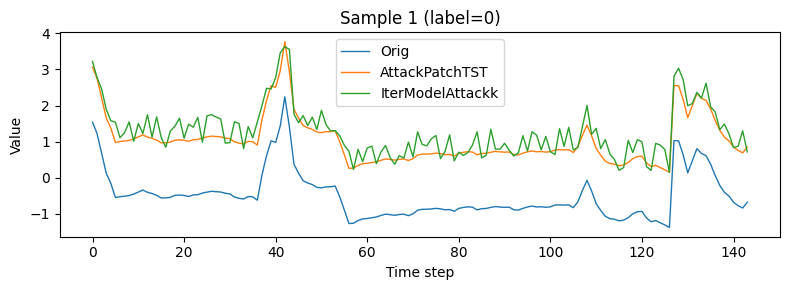

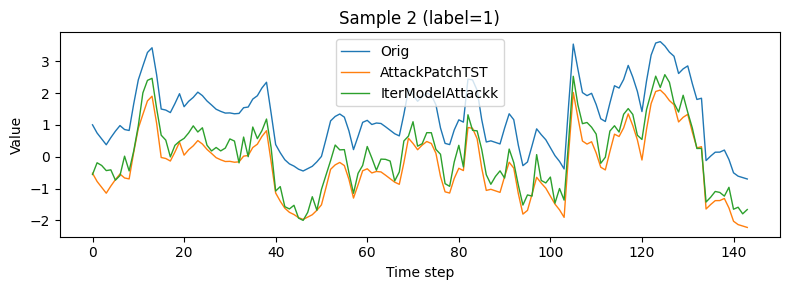

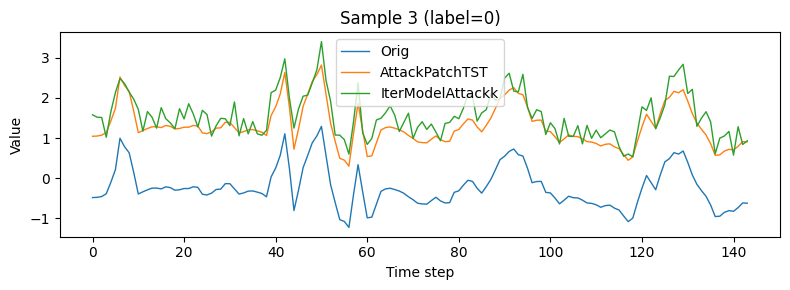

In [64]:
N_EXAMPLES = 3
FILTER = [2,3]
MBA_ATTACKS = [[mba_LSTM, mba_resCNN, mba_PatchTST, mba_iter][i] for i in FILTER]

# выбираем batch-и, вытаскиваем по одному примеру
chosen = []
for xb, yb in test_dl:
    for i in range(xb.size(0)):
        chosen.append((xb[i], yb[i]))
    if len(chosen) >= 50:       # достаточно выборки для случайного выбора
        break

examples = random.sample(chosen, N_EXAMPLES)

for sample_idx, (x_orig, y_lbl) in enumerate(examples, 1):
    x_orig = x_orig.to(device).unsqueeze(0)
    y_lbl_tensor = torch.tensor([y_lbl], device=device)  # создаем тензор для label
    x_np = x_orig.squeeze().cpu().numpy()
    x_adv_np_list = []
    
    for i, mba_attack in enumerate(MBA_ATTACKS):

        dummy_model = None  # или можно передать любую модель
        x_adv = mba_attack(dummy_model, x_orig, y_lbl_tensor)
        x_adv_np_list.append(x_adv.squeeze().cpu().numpy())

    plt.figure(figsize=(8, 3))
    plt.plot(x_np, label='Orig', linewidth=1)
    for i, x_adv_np in enumerate(x_adv_np_list):
        # Получаем имя класса внутреннего атакера
        attack_name = MBA_ATTACKS[i].attacker.__class__.__name__
        plt.plot(x_adv_np, label=f'{attack_name}', linewidth=1)
    plt.title(f'Sample {sample_idx} (label={int(y_lbl)})')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

FGSM            target accuracy after attack:  0.061
iFGSM5nonrand   target accuracy after attack:  0.072
iFGSM50nonrand  target accuracy after attack:  0.072


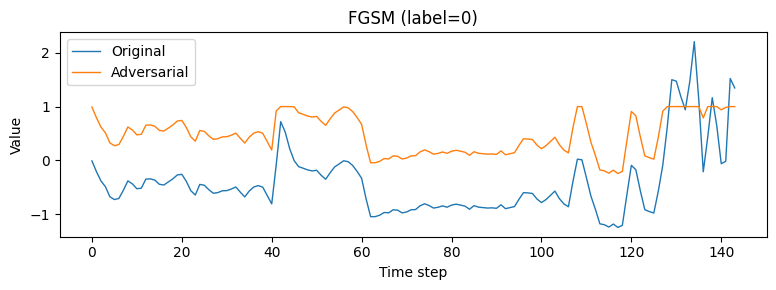

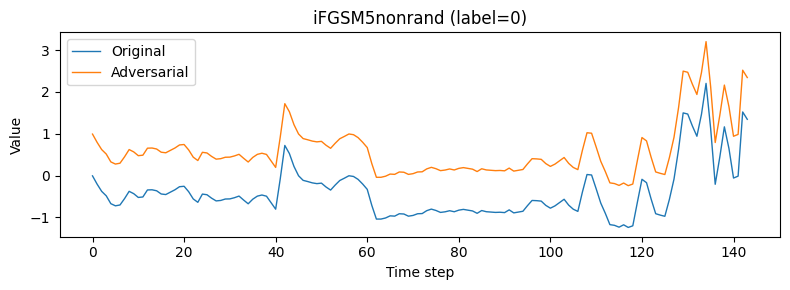

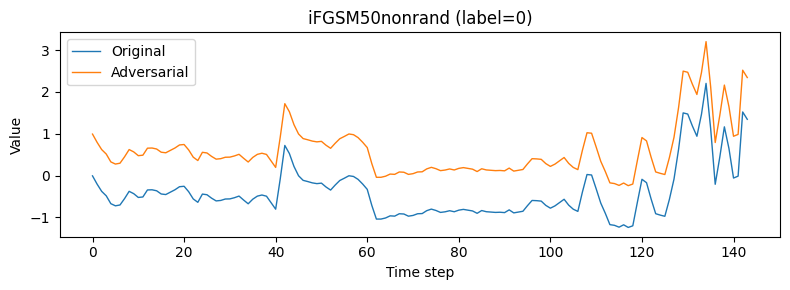

In [65]:
N_EXAMPLES = 3

EPS = 1
test_loader = test_dl
clf_model = clf_LSTM

attacks = { 'FGSM': fgsm_attack,
        #    'iFGSM_2_00': iFGSMAttack(eps=EPS, n_iter=2, momentum=0.0),
        #    'iFGSM_2_03': iFGSMAttack(eps=EPS, n_iter=2, momentum=0.3),
        #    'iFGSM_2_07': iFGSMAttack(eps=EPS, n_iter=20, momentum=0.7),
        #    'iFGSM_5_00': iFGSMAttack(eps=EPS, n_iter=5, momentum=0.0),
        #    'iFGSM_5_03': iFGSMAttack(eps=EPS, n_iter=5, momentum=0.3),
        #    'iFGSM_5_07': iFGSMAttack(eps=EPS, n_iter=5, momentum=0.7),

        'iFGSM5nonrand': iFGSMAttack(eps=EPS, n_iter=5, rand_init=False, momentum=0.6),
        'iFGSM50nonrand': iFGSMAttack(eps=EPS, n_iter=50, rand_init=False, momentum=0.0),
           }


idx = 7
for name, atk in attacks.items():
    fl_rate = -999
    ef_rate = -999
    # fl_rate = fooling_rate(model, test_loader, atk, device=device)
    # ef_rate = efficiency_rate(model, test_dl, atk, device=device)
    acc = accuracy_after_attack(clf_model, test_dl, atk, device=device)
    print(f'{name:<15} target accuracy after attack:  {acc:.3f}')


    x_orig = test_ds[idx][0].to(device)
    y_orig = test_ds[idx][1].to(device)

    x_orig = x_orig.unsqueeze(0)
    y_orig = y_orig.unsqueeze(0)

    x_adv = atk(clf_model, x_orig, y_orig)

    x_adv_np = x_adv[0].cpu().numpy()
    x_np = x_orig[0].cpu().numpy()

    # отдельный plot для каждой пары
    plt.figure(figsize=(8, 3))
    plt.plot(x_np,     label='Original', linewidth=1)
    plt.plot(x_adv_np, label=f'Adversarial', linewidth=1)
    plt.title(f'{name} (label={int(y_orig)})')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
plt.show()



